#### **Lets build a database!**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

#### **Lets first explore the different datasets and get a sense of what data we are working with**

In [2]:
file_names = ['game_log','park_codes','person_codes','team_codes']
df_dict = {}
for file in file_names:
    df_dict[file] = pd.read_csv(file+'.csv')

C:\Users\masv\AppData\Local\Temp\ipykernel_36004\2424821291.py:4: DtypeWarning: Columns (12,13,14,15,19,20,81,82,83,84,85,86,87,88,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dict[file] = pd.read_csv(file+'.csv')


In [3]:
df_dict['game_log']

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,NaN,1,WS3,NaN,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,NaN,2,RC1,NaN,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,NaN,3,CH1,NaN,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,NaN,2,TRO,NaN,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171902,20161002,0,Sun,MIL,NL,162,COL,NL,162,6,...,Pat Valaika,4.0,adamc001,Cristhian Adames,6.0,marqg001,German Marquez,1.0,NaN,Y
171903,20161002,0,Sun,NYN,NL,162,PHI,NL,162,2,...,Andres Blanco,6.0,altha001,Aaron Altherr,9.0,eickj001,Jerad Eickhoff,1.0,NaN,Y
171904,20161002,0,Sun,LAN,NL,162,SFN,NL,162,1,...,Joe Panik,4.0,gillc001,Conor Gillaspie,5.0,moorm003,Matt Moore,1.0,NaN,Y
171905,20161002,0,Sun,PIT,NL,162,SLN,NL,162,4,...,Jedd Gyorko,4.0,gricr001,Randal Grichuk,8.0,waina001,Adam Wainwright,1.0,NaN,Y


#### **Normalization of the tables**

Now, we need to normalize the tables and we need to create a primary key that interconnects the tables. There is no unique key in the table "game_logs" and needs to be created. This can be done in various ways, by e.g. consulting the data for viable columns or create custom columns. 

Luckily, Retrosheet have already built up a system for how to uniquely adress each game, and it is as follows:


**id**: Each game begins with a twelve character ID record which identifies the date, home team, and number of the game. For example, ATL198304080 should be read as follows. The first three characters identify the home team (the Braves). The next four are the year (1983). The next two are the month (April) using the standard numeric notation, 04, followed by the day (08). The last digit indicates if this is a single game (0), first game (1) or second game (2) if more than one game is played during a day, usually a double header The id record starts the description of a game thus ending the description of the preceding game in the file.



Here it can be seen that some of the older team names have only two letters and then a number. But lets treat the number as part of the name.

In [4]:
def create_retro_id(row):
    #row['date'] = pd.to_datetime(row['date'],format='%Y%m%d')
    id = row['h_name']+str(row['date'])+str(row['number_of_game'])
    return id

df_dict['game_log']['id'] = df_dict['game_log'].apply(create_retro_id,axis=1)
df_dict['game_log']['id']

0         FW1187105040
1         WS3187105050
2         RC1187105060
3         CH1187105080
4         TRO187105090
              ...     
171902    COL201610020
171903    PHI201610020
171904    SFN201610020
171905    SLN201610020
171906    WAS201610020
Name: id, Length: 171907, dtype: object

Lets create a database and insert the csv files into it!

In [5]:
conn = sqlite3.connect('sqlite_database') 
c = conn.cursor()

for file in file_names:
    df_dict[file].to_sql(file,conn,if_exists='replace',index=False)
    conn.commit()

conn.close()

#### **Normalization and Schema of the tables**


 - After lots of research in the tables, the folloing schema was decided:

 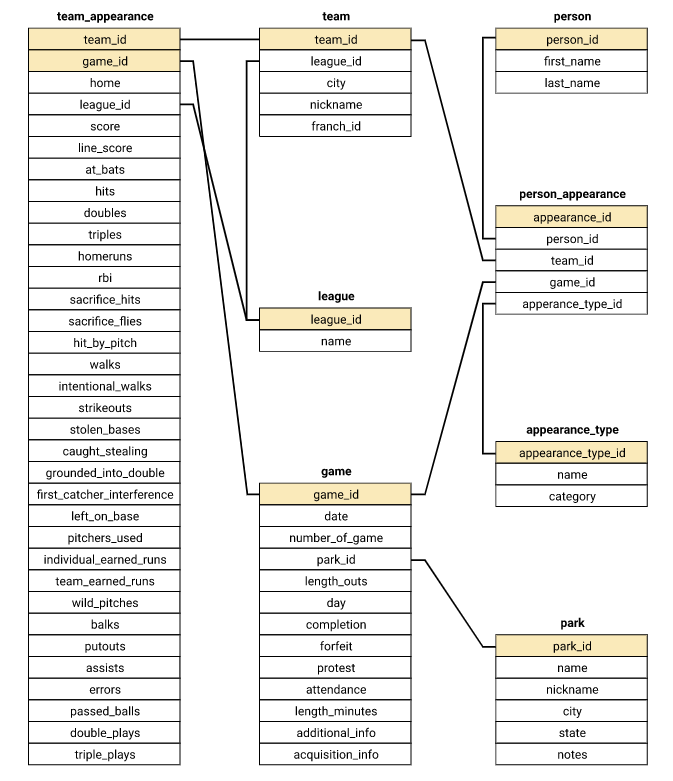 


Some comments on the table:

**person**
 - Each of the "debut" columns have been omitted, as the data will be able to be found from other tables.
 - Since the game log file has no data on coaches, we made the decision to not include this data.
 
 
 **park**
 - The start, end, and league columns contain data that is found in the main game log and can be removed.
 
 
 **league**
 - Because some of the older leagues are not well known, we will create a table to store league names.
 
 
 **appearance_type**
 - Our appearance table will include data on players with positions, umpires, managers, and awards (like winning pitcher). This table will store information on what different types of appearances are available.



 Lets first create the person table






In [6]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
#c.execute('CREATE TABLE person(id text PRIMARY KEY,first_name text,last_name text)' )
query = 'INSERT INTO person SELECT id,first,last from person_codes'
c.execute(query)
c.close()

In [7]:
r_df = pd.read_sql("select * from person",conn)
r_df


,id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron
3,aased001,Don,Aase
4,abada001,Andy,Abad
...,...,...,...
20489,zuvep001,Paul,Zuvella
20490,zuveg101,George,Zuverink
20491,zwild101,Dutch,Zwilling
20492,zycht001,Tony,Zych


**And now the park table**

In [8]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
#c.execute('CREATE TABLE park(park_id text PRIMARY KEY,name text,nickname text,city text,state text, notes text)')
c.close()


In [10]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
query = 'INSERT OR REPLACE INTO park SELECT park_id,name,aka,city,state,notes from park_codes'
c.execute(query)
c.close()

**League and apperance type**

In [27]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
#c.execute('CREATE TABLE league(league_id text PRIMARY KEY,name text)')
#c.execute('CREATE TABLE apperance(apperance_type_id text PRIMARY KEY,name text,category text)')

c.close()

In [40]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
query_league = 'INSERT OR REPLACE INTO league(league_id) SELECT HØSTA_league FROM game_log'
c.execute(query)
conn.commit()
c.close()

In [22]:
conn = sqlite3.connect('sqlite_database')
c = conn.cursor()
query_league = 'SELECT * FROM league'
row= c.execute(query).fetchall()
conn.commit()

c.close()

In [37]:
r_df = pd.read_sql("select * from game_log",conn)
r_df

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info,id
0,18710504,0,Thu,CL1,None,1,FW1,None,1,0,...,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,None,Y,FW1187105040
1,18710505,0,Fri,BS1,None,1,WS3,None,1,20,...,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y,WS3187105050
2,18710506,0,Sat,CL1,None,2,RC1,None,1,12,...,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,None,Y,RC1187105060
3,18710508,0,Mon,CL1,None,3,CH1,None,1,12,...,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,None,Y,CH1187105080
4,18710509,0,Tue,BS1,None,2,TRO,None,1,9,...,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y,TRO187105090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171902,20161002,0,Sun,MIL,NL,162,COL,NL,162,6,...,4.0,adamc001,Cristhian Adames,6.0,marqg001,German Marquez,1.0,None,Y,COL201610020
171903,20161002,0,Sun,NYN,NL,162,PHI,NL,162,2,...,6.0,altha001,Aaron Altherr,9.0,eickj001,Jerad Eickhoff,1.0,None,Y,PHI201610020
171904,20161002,0,Sun,LAN,NL,162,SFN,NL,162,1,...,4.0,gillc001,Conor Gillaspie,5.0,moorm003,Matt Moore,1.0,None,Y,SFN201610020
171905,20161002,0,Sun,PIT,NL,162,SLN,NL,162,4,...,4.0,gricr001,Randal Grichuk,8.0,waina001,Adam Wainwright,1.0,None,Y,SLN201610020


In [34]:
league_df = r_df[['v_league','v_name']].value_counts()
league_df
#df.to_sql(table_name,conn,if_exists='replace',index=False)

v_league  v_name
NL        CHN       8870
          PHI       8637
          PIT       8431
          CIN       8209
          SLN       8106
                    ... 
AA        RIC         24
          ML3         15
UA        WIL         11
          SPU          9
          ALT          7
Length: 123, dtype: int64

In [39]:
for col in r_df.columns:
    print(col)

date
number_of_game
day_of_week
v_name
v_league
v_game_number
h_name
h_league
h_game_number
v_score
h_score
length_outs
day_night
completion
forfeit
protest
park_id
attendance
length_minutes
v_line_score
h_line_score
v_at_bats
v_hits
v_doubles
v_triples
v_homeruns
v_rbi
v_sacrifice_hits
v_sacrifice_flies
v_hit_by_pitch
v_walks
v_intentional_walks
v_strikeouts
v_stolen_bases
v_caught_stealing
v_grounded_into_double
v_first_catcher_interference
v_left_on_base
v_pitchers_used
v_individual_earned_runs
v_team_earned_runs
v_wild_pitches
v_balks
v_putouts
v_assists
v_errors
v_passed_balls
v_double_plays
v_triple_plays
h_at_bats
h_hits
h_doubles
h_triples
h_homeruns
h_rbi
h_sacrifice_hits
h_sacrifice_flies
h_hit_by_pitch
h_walks
h_intentional_walks
h_strikeouts
h_stolen_bases
h_caught_stealing
h_grounded_into_double
h_first_catcher_interference
h_left_on_base
h_pitchers_used
h_individual_earned_runs
h_team_earned_runs
h_wild_pitches
h_balks
h_putouts
h_assists
h_errors
h_passed_balls
h_double_